In [26]:

import jax
jax.config.update('jax_enable_x64',True)




In [27]:


import numpyro
from NSF import NeuralSpline1D
from flow import Normal,Flow,transform,Serial
from SkewNormalPlus import SkewNormalPlus as snp

In [28]:
from jax import random
import jax_cosmo as jc
from jax_cosmo import Cosmology, background
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax.scipy.stats import norm

In [29]:

@jit
def make_training_set(key,z_s,M0=-19.5,sigma_int=0.1,h=0.7324,Om0=0.28,w=-1,mu_cut=21,sigma_cut=0.01):




    cosmo_jax = Cosmology(Omega_c=Om0, h=h, w0=w, Omega_b=0, n_s= 0.96, sigma8=200000, Omega_k=0, wa=0)

    n_sne=len(z_s)

    d_s=background.transverse_comoving_distance(cosmo_jax, 1/(1+z_s))

    mu_s=5*np.log10((1+z_s)/h*d_s*1e6/10)

    m0_s=M0+mu_s

    m_s=random.normal(key, (len(m0_s),))*sigma_int+m0_s

    key, _ = random.split(key)

    p_s=norm.cdf(-m_s, loc=-mu_cut, scale=sigma_cut)

    sel_s=random.bernoulli(key, p=p_s)

    return m0_s,m_s,sel_s



def minmax_fit_and_scale(X):
  max= np.max(X,axis=0)
  min = np.min(X,axis=0)
  X_std = (X - min) / (max-min)
  return X_std,min,max


def minmax_scale(X,min,max):
  return (X - min) / (max - min)







In [30]:
from jax.example_libraries import stax, optimizers

from jax.example_libraries.stax import (Dense, Tanh, Flatten, Relu, LogSoftmax, Softmax, Exp,Sigmoid,Softplus,LeakyRelu)

def network(rng,conditional_dim,out_dim, hidden_dim):
    init_fun,apply_fun=stax.serial(stax.Dense(hidden_dim),  Relu, stax.Dense(1024),Relu,stax.Dense(hidden_dim), Relu, stax.Dense(out_dim),)
    _, params = init_fun(rng, (conditional_dim,))

    return params,apply_fun
'''
def network(rng,conditional_dim,out_dim, hidden_dim):
    init_fun,apply_fun=stax.serial(stax.Dense(hidden_dim), Tanh, stax.Dense(1024),Tanh,stax.Dense(hidden_dim), Tanh, stax.Dense(out_dim),)
    _, params = init_fun(rng, (conditional_dim,))
    return params,apply_fun
'''
rng, flow_rng = random.split(random.PRNGKey(0))

init_fun = Flow(Serial(*(NeuralSpline1D(network,hidden_dim=128,K=30,B=3),)*4),prior=Normal())

params, log_pdf, sample = init_fun(flow_rng,1 )

In [31]:
opt_init, opt_update, get_params = optimizers.adam(step_size=5e-4)
opt_state = opt_init(params)

In [32]:
def loss_fn(params, inputs):
    return -log_pdf(params, inputs).mean()

@jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)

    loss,gradients = value_and_grad(loss_fn)(params,inputs)
    return loss, opt_update(i, gradients, opt_state)

def minmax_unscale(X,min,max):
  return X * (max - min) + min


epoch:  0  loss:  1.2324216429042367
17.754266576457482 22.877640472715154
17.754266576457482 22.877640472715154
17.754266576457482 22.877640472715154
17.754266576457482 22.877640472715154
17.754266576457482 22.877640472715154


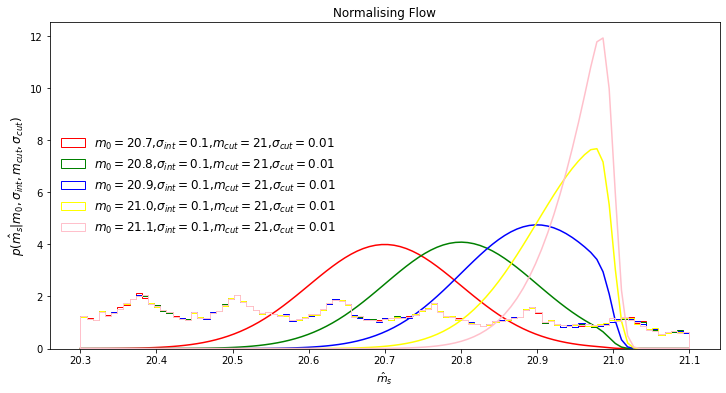

epoch:  1  loss:  1.1037363723026863
epoch:  2  loss:  1.1742340812614898
epoch:  3  loss:  1.2668156121359453
epoch:  4  loss:  1.0836545300028388
epoch:  5  loss:  1.0232169736648065
epoch:  6  loss:  0.9891188473075517
epoch:  7  loss:  0.9588866038718541
epoch:  8  loss:  1.0386644630023416
epoch:  9  loss:  0.9799453161971574
epoch:  10  loss:  0.7350120815326693
epoch:  11  loss:  0.9293834357320436
epoch:  12  loss:  0.7521354523805788
epoch:  13  loss:  0.5319967676625739
epoch:  14  loss:  0.6020095392378326
epoch:  15  loss:  0.4475424263218903
epoch:  16  loss:  0.6246516432646675
epoch:  17  loss:  0.18205481944247998
epoch:  18  loss:  0.18662265383876922
epoch:  19  loss:  0.06820046478203079
epoch:  20  loss:  0.248516979988225
epoch:  21  loss:  0.39235213629282384
epoch:  22  loss:  -0.0004122597784749633
epoch:  23  loss:  -0.11530329720981164
epoch:  24  loss:  -0.38070879485095727
epoch:  25  loss:  0.44711922408140914
epoch:  26  loss:  -0.24347184394782095
epoch: 

epoch:  211  loss:  -1.2100332112578207
epoch:  212  loss:  -0.6319667063774667
epoch:  213  loss:  -1.0166494821123466
epoch:  214  loss:  -1.176517128562858
epoch:  215  loss:  -1.1606520915195986
epoch:  216  loss:  -0.19232311823657425
epoch:  217  loss:  -1.2826103275745018
epoch:  218  loss:  -0.8099787640799918
epoch:  219  loss:  -0.9972907254025053
epoch:  220  loss:  -0.13550401259041875
epoch:  221  loss:  -0.3610578811642357
epoch:  222  loss:  -1.0790209144672194
epoch:  223  loss:  -0.7766545118240242
epoch:  224  loss:  -0.9589179035439586
epoch:  225  loss:  -0.7823819606398437
epoch:  226  loss:  -0.620016848103561
epoch:  227  loss:  -0.4640464093778849
epoch:  228  loss:  -0.7407332217956942
epoch:  229  loss:  -0.187546169738699
epoch:  230  loss:  -0.7375752061833584
epoch:  231  loss:  -1.0336357577599602
epoch:  232  loss:  -0.6230650486899854
epoch:  233  loss:  -0.3611566527562643
epoch:  234  loss:  -0.776037158224919
epoch:  235  loss:  -0.6459646496814857
ep

epoch:  418  loss:  -0.7498586273571698
epoch:  419  loss:  -1.1158499458263507
epoch:  420  loss:  -0.8457858444950396
epoch:  421  loss:  0.07435952209756161
epoch:  422  loss:  -1.033705275165799
epoch:  423  loss:  -0.2992726985730715
epoch:  424  loss:  -0.8028673158772228
epoch:  425  loss:  -0.7997327777945231
epoch:  426  loss:  -1.0929332413408392
epoch:  427  loss:  -0.8294816760019439
epoch:  428  loss:  -1.0015046284097433
epoch:  429  loss:  -1.2694811071500858
epoch:  430  loss:  -0.9823450583834483
epoch:  431  loss:  -1.0946122877017241
epoch:  432  loss:  -1.1604807407799032
epoch:  433  loss:  -1.2938774009476193
epoch:  434  loss:  -0.8469528805219743
epoch:  435  loss:  -0.9159758334631238
epoch:  436  loss:  -0.9548285695660159
epoch:  437  loss:  -1.167396920002243
epoch:  438  loss:  -1.1336475993504145
epoch:  439  loss:  -0.8848920835665783
epoch:  440  loss:  -1.321989782734298
epoch:  441  loss:  -0.9220292267435108
epoch:  442  loss:  -0.8255020732983926
epo

epoch:  624  loss:  -0.8825173300920242
epoch:  625  loss:  -0.32773123148738753
epoch:  626  loss:  -0.9332461186465787
epoch:  627  loss:  1.5397590702650372
epoch:  628  loss:  -0.7354479165041692
epoch:  629  loss:  -0.6653027156876099
epoch:  630  loss:  -1.2463876971634635
epoch:  631  loss:  -0.9736274761551349
epoch:  632  loss:  -0.7753690345954501
epoch:  633  loss:  -0.8182821819833664
epoch:  634  loss:  -1.1951825102996185
epoch:  635  loss:  -0.5731116124496822
epoch:  636  loss:  -1.0843631734984993
epoch:  637  loss:  -0.8020001468657556
epoch:  638  loss:  -0.24033766521663769
epoch:  639  loss:  -0.7598800150730763
epoch:  640  loss:  0.042350284325212824
epoch:  641  loss:  -1.2509727850195762
epoch:  642  loss:  -1.2550716619034612
epoch:  643  loss:  -1.0554369222123037
epoch:  644  loss:  -0.5233802504800631
epoch:  645  loss:  -0.9742178878256385
epoch:  646  loss:  -0.8365429588894867
epoch:  647  loss:  -0.8043884865907135
epoch:  648  loss:  -1.047769994215112

epoch:  831  loss:  -0.7870779182782358
epoch:  832  loss:  -1.0746542690719139
epoch:  833  loss:  -1.0671319320344024
epoch:  834  loss:  -0.9895231518157966
epoch:  835  loss:  -0.6488804756188985
epoch:  836  loss:  -0.8309775838713461
epoch:  837  loss:  1.3854614100288045
epoch:  838  loss:  -0.020194407251647405
epoch:  839  loss:  -0.7533494520321244
epoch:  840  loss:  -1.181943997013505
epoch:  841  loss:  -1.0343033714763687
epoch:  842  loss:  -1.0506162377493886
epoch:  843  loss:  -0.9175051700667682
epoch:  844  loss:  -1.112755549403683
epoch:  845  loss:  -1.1757672706098687
epoch:  846  loss:  -1.2602122476086655
epoch:  847  loss:  -0.32642592253162545
epoch:  848  loss:  -1.3359434945985635
epoch:  849  loss:  -1.1508220343199131
epoch:  850  loss:  0.08265417701210148
epoch:  851  loss:  -1.0109858249308998
epoch:  852  loss:  -0.5199171799470608
epoch:  853  loss:  -1.0350171234956256
epoch:  854  loss:  -0.036626833687933576
epoch:  855  loss:  -1.172753764692582

epoch:  1036  loss:  -0.27755820687181265
epoch:  1037  loss:  -1.0744851182333115
epoch:  1038  loss:  -1.0545429473012875
epoch:  1039  loss:  -1.1706051442376881
epoch:  1040  loss:  -0.9041530946804516
epoch:  1041  loss:  -1.0309050144280827
epoch:  1042  loss:  0.2840074164759679
epoch:  1043  loss:  -1.0237672362360632
epoch:  1044  loss:  -1.0943666366728413
epoch:  1045  loss:  -0.8371834777648812
epoch:  1046  loss:  -0.8310261522742127
epoch:  1047  loss:  -0.8887982751692254
epoch:  1048  loss:  -0.5901938722224802
epoch:  1049  loss:  -0.6938870523672147
epoch:  1050  loss:  -1.1176377973694516
epoch:  1051  loss:  -0.7730647190374931
epoch:  1052  loss:  -0.7751775496823408
epoch:  1053  loss:  -0.2546938173043513
epoch:  1054  loss:  -1.1556617597641614
epoch:  1055  loss:  -0.8801892226954752
epoch:  1056  loss:  -0.8703193845242527
epoch:  1057  loss:  -0.5682638106980193
epoch:  1058  loss:  -1.0931357771439199
epoch:  1059  loss:  -0.7823008863460257
epoch:  1060  lo

epoch:  1239  loss:  -1.137748655521108
epoch:  1240  loss:  -0.7744670024963735
epoch:  1241  loss:  -1.2696674036191369
epoch:  1242  loss:  -1.0334328940746078
epoch:  1243  loss:  -1.0304381649168879
epoch:  1244  loss:  -0.8981483154995049
epoch:  1245  loss:  -0.8674482619513032
epoch:  1246  loss:  -0.8855939409314404
epoch:  1247  loss:  -0.915689480893865
epoch:  1248  loss:  -0.9553086354748812
epoch:  1249  loss:  -1.3348729311526766
epoch:  1250  loss:  -0.9314640624829216
epoch:  1251  loss:  -1.0755143162606702
epoch:  1252  loss:  -1.0052369750654073
epoch:  1253  loss:  -1.12148733336461
epoch:  1254  loss:  -1.0564741730244613
epoch:  1255  loss:  -0.7669652405314323
epoch:  1256  loss:  -1.0890927475856715
epoch:  1257  loss:  -1.144797958631385
epoch:  1258  loss:  -0.784513459890755
epoch:  1259  loss:  -0.9244391483557868
epoch:  1260  loss:  -1.4644961366048044
epoch:  1261  loss:  -0.9865901673406755
epoch:  1262  loss:  -1.1110984514915836
epoch:  1263  loss:  -

epoch:  1441  loss:  -1.072676830004805
epoch:  1442  loss:  -0.6975266665692693
epoch:  1443  loss:  -1.1397802500588328
epoch:  1444  loss:  -0.6685794434809932
epoch:  1445  loss:  -1.21466681584225
epoch:  1446  loss:  -1.380153286348768
epoch:  1447  loss:  -0.40031004447088947
epoch:  1448  loss:  -0.8464394794308453
epoch:  1449  loss:  -0.8225374518732476
epoch:  1450  loss:  -0.9747015919986619
epoch:  1451  loss:  -1.0783441011116992
epoch:  1452  loss:  -1.425350125082561
epoch:  1453  loss:  -0.8274082219219352
epoch:  1454  loss:  -0.6503588824037457
epoch:  1455  loss:  -0.7519616396503405
epoch:  1456  loss:  -0.8349020265459572
epoch:  1457  loss:  -1.0469825404436452
epoch:  1458  loss:  -0.9869442438376761
epoch:  1459  loss:  -0.5919713893590417
epoch:  1460  loss:  -0.9957057676557183
epoch:  1461  loss:  -0.480623928872876
epoch:  1462  loss:  -1.11066957574352
epoch:  1463  loss:  -0.5990197058042079
epoch:  1464  loss:  -1.156418192893451
epoch:  1465  loss:  -1.

epoch:  1643  loss:  -0.7368463190038506
epoch:  1644  loss:  -1.0136857399469703
epoch:  1645  loss:  0.555862317968239
epoch:  1646  loss:  -0.8565641068590533
epoch:  1647  loss:  0.4188627445732775
epoch:  1648  loss:  -0.788160015464521
epoch:  1649  loss:  -1.1974982618630639
epoch:  1650  loss:  -0.5908749619768742
epoch:  1651  loss:  -0.5979775403440307
epoch:  1652  loss:  -0.844326489024834
epoch:  1653  loss:  -0.5239853550908878
epoch:  1654  loss:  -0.6063905017040127
epoch:  1655  loss:  -1.0812727900617356
epoch:  1656  loss:  -1.0347912601326226
epoch:  1657  loss:  -1.0421408235110152
epoch:  1658  loss:  -0.7299541627285345
epoch:  1659  loss:  -0.8267348563916506
epoch:  1660  loss:  -0.9825897010273993
epoch:  1661  loss:  -0.932943547815042
epoch:  1662  loss:  1.3296182188706525
epoch:  1663  loss:  -1.0988864812620835
epoch:  1664  loss:  -1.3135731324852833
epoch:  1665  loss:  -0.8496646733010355
epoch:  1666  loss:  -1.1589735890413466
epoch:  1667  loss:  -0

epoch:  1844  loss:  -1.4259779265667807
epoch:  1845  loss:  -1.0815772230266611
epoch:  1846  loss:  -1.1440036823432715
epoch:  1847  loss:  -1.3573514207809316
epoch:  1848  loss:  -1.015983198009946
epoch:  1849  loss:  -0.9479373734009048
epoch:  1850  loss:  -0.6741154797365677
epoch:  1851  loss:  -0.8984276546157951
epoch:  1852  loss:  -0.8762281356907049
epoch:  1853  loss:  -1.3035212015575695
epoch:  1854  loss:  -0.8278112101793103
epoch:  1855  loss:  -0.8967794855192506
epoch:  1856  loss:  -0.9031803368426745
epoch:  1857  loss:  -0.6320110321230001
epoch:  1858  loss:  -1.4933958987725222
epoch:  1859  loss:  -1.4983190240236004
epoch:  1860  loss:  -0.9298239243051944
epoch:  1861  loss:  -1.1119204641180973
epoch:  1862  loss:  -1.094741806515524
epoch:  1863  loss:  -0.9444848491472314
epoch:  1864  loss:  -1.4289754547747713
epoch:  1865  loss:  -0.8457269420486965
epoch:  1866  loss:  -0.8143240620174504
epoch:  1867  loss:  -1.036462566353098
epoch:  1868  loss:

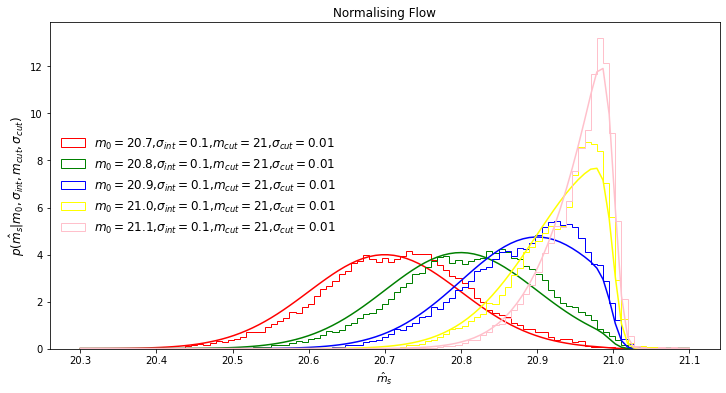

epoch:  2001  loss:  -1.2432904208001365
epoch:  2002  loss:  -0.8293364723622707
epoch:  2003  loss:  -1.1295846352337449
epoch:  2004  loss:  -0.8585545113229118
epoch:  2005  loss:  -0.3996728026729167
epoch:  2006  loss:  -1.0092020490082616
epoch:  2007  loss:  -1.0072021925172747
epoch:  2008  loss:  -0.9623545615614676
epoch:  2009  loss:  -1.0337947101278167
epoch:  2010  loss:  -0.8445995656471116
epoch:  2011  loss:  -1.0678645420528414
epoch:  2012  loss:  -1.0672697061853378
epoch:  2013  loss:  -0.7899663772553818
epoch:  2014  loss:  -0.9478380548417243
epoch:  2015  loss:  -1.019254628422054
epoch:  2016  loss:  -0.8260385923780379
epoch:  2017  loss:  -0.61655654360058
epoch:  2018  loss:  -0.7986808872851928
epoch:  2019  loss:  -0.9486870154327546
epoch:  2020  loss:  -1.0600607833237063
epoch:  2021  loss:  -1.0293854058692213
epoch:  2022  loss:  -1.237407270413612
epoch:  2023  loss:  -0.8218339959375778
epoch:  2024  loss:  -1.4892931780564804
epoch:  2025  loss: 

epoch:  2202  loss:  -0.9958936013961238
epoch:  2203  loss:  -0.5465645016869571
epoch:  2204  loss:  -0.9179188336727739
epoch:  2205  loss:  -1.1267992428836593
epoch:  2206  loss:  -1.0338751007814708
epoch:  2207  loss:  -1.275470460675921
epoch:  2208  loss:  -1.099062742890888
epoch:  2209  loss:  -0.9503860025721362
epoch:  2210  loss:  -0.8186121614898924
epoch:  2211  loss:  -1.264734080004297
epoch:  2212  loss:  -1.1734241830394383
epoch:  2213  loss:  -0.6853139333682369
epoch:  2214  loss:  -0.9701254152200782
epoch:  2215  loss:  -0.7237907474202221
epoch:  2216  loss:  -1.1586601325746302
epoch:  2217  loss:  -0.8225280276144443
epoch:  2218  loss:  -0.8205454187081817
epoch:  2219  loss:  -0.9787735303656953
epoch:  2220  loss:  -0.858007275991125
epoch:  2221  loss:  -0.5801485066282281
epoch:  2222  loss:  -0.8421456232594408
epoch:  2223  loss:  -0.8809581130377537
epoch:  2224  loss:  -0.9341407574077826
epoch:  2225  loss:  -0.953044071603013
epoch:  2226  loss:  

epoch:  2403  loss:  -1.3152281787878761
epoch:  2404  loss:  -1.0737559758237993
epoch:  2405  loss:  -0.960137166001349
epoch:  2406  loss:  -0.947036286448042
epoch:  2407  loss:  -0.849688755206405
epoch:  2408  loss:  -0.8841561419354109
epoch:  2409  loss:  -0.9500843997818472
epoch:  2410  loss:  -0.9212278808089018
epoch:  2411  loss:  -1.1465631348618692
epoch:  2412  loss:  -0.9385094940945143
epoch:  2413  loss:  -0.869289293312517
epoch:  2414  loss:  -0.917798600108724
epoch:  2415  loss:  -1.1799912625821376
epoch:  2416  loss:  -0.7988834158703018
epoch:  2417  loss:  -0.26592761651366453
epoch:  2418  loss:  -1.1909191247323654
epoch:  2419  loss:  -1.04354457621458
epoch:  2420  loss:  -1.1017774516419705
epoch:  2421  loss:  -0.9334402970817084
epoch:  2422  loss:  -0.9491242892756793
epoch:  2423  loss:  -1.012943489660976
epoch:  2424  loss:  -0.5633470787387233
epoch:  2425  loss:  -0.8321276183868548
epoch:  2426  loss:  -0.8285659662711848
epoch:  2427  loss:  -0

epoch:  2604  loss:  -1.1759070712798667
epoch:  2605  loss:  -1.5371421578188498
epoch:  2606  loss:  -0.6636312294925749
epoch:  2607  loss:  0.7837179286710171
epoch:  2608  loss:  -1.2313185517978982
epoch:  2609  loss:  -1.1617453841191745
epoch:  2610  loss:  -0.6804202063361522
epoch:  2611  loss:  -0.8781764398760149
epoch:  2612  loss:  -1.0220890744977655
epoch:  2613  loss:  -0.9254821960246677
epoch:  2614  loss:  -1.325731167752108
epoch:  2615  loss:  -1.1696444923420135
epoch:  2616  loss:  -1.0796471927371685
epoch:  2617  loss:  -1.1919753337448507
epoch:  2618  loss:  -1.1727233827765193
epoch:  2619  loss:  -0.37215580041035
epoch:  2620  loss:  -0.8644557425345853
epoch:  2621  loss:  -1.2669521435491753
epoch:  2622  loss:  -1.117947650245574
epoch:  2623  loss:  -0.8747801031354223
epoch:  2624  loss:  -0.9415275656891665
epoch:  2625  loss:  -0.8544484885155453
epoch:  2626  loss:  -0.9462060878526082
epoch:  2627  loss:  -1.0317198815907347
epoch:  2628  loss:  

epoch:  2806  loss:  -0.9701754107498466
epoch:  2807  loss:  -0.8736863035779286
epoch:  2808  loss:  -1.1193074008381796
epoch:  2809  loss:  -1.044292966932477
epoch:  2810  loss:  -0.8798787712449907
epoch:  2811  loss:  -0.8683816517041733
epoch:  2812  loss:  -0.8744739786604836
epoch:  2813  loss:  -0.7980226482915437
epoch:  2814  loss:  -0.5192034102512556
epoch:  2815  loss:  -0.3465440347830073
epoch:  2816  loss:  -0.5059170864540556
epoch:  2817  loss:  -1.2242061878542367
epoch:  2818  loss:  -1.0804320216895384
epoch:  2819  loss:  -0.8802726285060762
epoch:  2820  loss:  -0.968905646274937
epoch:  2821  loss:  -1.1942640109764164
epoch:  2822  loss:  -1.0690406867633366
epoch:  2823  loss:  -0.9298303481914468
epoch:  2824  loss:  -0.8950653624239024
epoch:  2825  loss:  -0.6080734844542798
epoch:  2826  loss:  -0.9190945880322131
epoch:  2827  loss:  -1.0116656445646404
epoch:  2828  loss:  -0.28776972360767994
epoch:  2829  loss:  -0.6810288173176586
epoch:  2830  los

epoch:  3009  loss:  -0.8608269131240057
epoch:  3010  loss:  -0.9310617285108329
epoch:  3011  loss:  -1.4370032889588875
epoch:  3012  loss:  -1.0572059475785256
epoch:  3013  loss:  -0.9664879384539884
epoch:  3014  loss:  -0.3498664536940448
epoch:  3015  loss:  -0.4612406918081644
epoch:  3016  loss:  -1.2463692483200604
epoch:  3017  loss:  -1.243062082391283
epoch:  3018  loss:  -0.8369366041135808
epoch:  3019  loss:  -0.6733950516392907
epoch:  3020  loss:  -1.0677980237270768
epoch:  3021  loss:  -0.8888687255118253
epoch:  3022  loss:  -0.6852071212721241
epoch:  3023  loss:  -0.8887934809140843
epoch:  3024  loss:  -1.2814571948766476
epoch:  3025  loss:  -0.9740328220292118
epoch:  3026  loss:  -0.7131690748951234
epoch:  3027  loss:  -0.49624410607248537
epoch:  3028  loss:  -0.8088413560098707
epoch:  3029  loss:  -0.8982641405206655
epoch:  3030  loss:  -0.8776170063822497
epoch:  3031  loss:  -1.0335047493669305
epoch:  3032  loss:  -0.9146528286622885
epoch:  3033  lo

epoch:  3210  loss:  -1.0442654323391931
epoch:  3211  loss:  -0.7823413628252218
epoch:  3212  loss:  -0.758661280476289
epoch:  3213  loss:  -0.549568398276346
epoch:  3214  loss:  -0.9741007517803388
epoch:  3215  loss:  -1.014024216481821
epoch:  3216  loss:  -1.0654976496950708
epoch:  3217  loss:  -0.5896273620983886
epoch:  3218  loss:  -1.0272261702283176
epoch:  3219  loss:  -1.0366687249820683
epoch:  3220  loss:  -1.093303363555
epoch:  3221  loss:  -0.9781129605227498
epoch:  3222  loss:  -1.1006457685491682
epoch:  3223  loss:  -1.2922387283154337
epoch:  3224  loss:  -0.9606113107475996
epoch:  3225  loss:  -0.8625653586308764
epoch:  3226  loss:  0.3434830833059151
epoch:  3227  loss:  -0.8698006079938532
epoch:  3228  loss:  -1.4992016376672177
epoch:  3229  loss:  -1.0466286933269797
epoch:  3230  loss:  -0.7808847028658716
epoch:  3231  loss:  -1.1152690419328424
epoch:  3232  loss:  -0.9870097067818502
epoch:  3233  loss:  -0.8295729233174405
epoch:  3234  loss:  -0.

epoch:  3413  loss:  -0.9205560190647245
epoch:  3414  loss:  -0.9831826786550175
epoch:  3415  loss:  -1.2275144538347693
epoch:  3416  loss:  -1.0242839514357305
epoch:  3417  loss:  -0.8182860044005297
epoch:  3418  loss:  -1.2906736577003544
epoch:  3419  loss:  -0.6168908515723185
epoch:  3420  loss:  -1.237826253340641
epoch:  3421  loss:  -0.9263730481605141
epoch:  3422  loss:  -1.0244926219476058
epoch:  3423  loss:  -0.9796929284594648
epoch:  3424  loss:  -0.5302847541893624
epoch:  3425  loss:  -1.2240028536788041
epoch:  3426  loss:  -1.268737753600135
epoch:  3427  loss:  -0.8565956431640754
epoch:  3428  loss:  -0.9402003882092818
epoch:  3429  loss:  -1.0944652973711313
epoch:  3430  loss:  -1.2300560286273492
epoch:  3431  loss:  -0.8152118481139796
epoch:  3432  loss:  -0.9799650184360811
epoch:  3433  loss:  -1.0542968796480734
epoch:  3434  loss:  -1.2797542908197617
epoch:  3435  loss:  -1.1324566540616634
epoch:  3436  loss:  -1.0116317359940497
epoch:  3437  loss

epoch:  3614  loss:  -0.9563532979941195
epoch:  3615  loss:  -1.1694031231186415
epoch:  3616  loss:  -1.0430371266924128
epoch:  3617  loss:  -1.2555778848377872
epoch:  3618  loss:  -1.1813048603066154
epoch:  3619  loss:  -0.2566891261237192
epoch:  3620  loss:  -1.0764982465163215
epoch:  3621  loss:  -0.8192234189888044
epoch:  3622  loss:  -0.9816623872280178
epoch:  3623  loss:  -0.8667632453866168
epoch:  3624  loss:  -1.0357547860730039
epoch:  3625  loss:  -0.9362728801554674
epoch:  3626  loss:  -0.84584050452996
epoch:  3627  loss:  -1.1532534955023448
epoch:  3628  loss:  -0.49136200078933523
epoch:  3629  loss:  -0.7642298287754438
epoch:  3630  loss:  -1.2766062559909355
epoch:  3631  loss:  -0.908982077824026
epoch:  3632  loss:  -0.9828031920537484
epoch:  3633  loss:  -1.0854640308996066
epoch:  3634  loss:  -1.1013940653571903
epoch:  3635  loss:  1.5460712815642503
epoch:  3636  loss:  -1.103419024075911
epoch:  3637  loss:  -0.9654933284874138
epoch:  3638  loss: 

epoch:  3815  loss:  1.5940906824015795
epoch:  3816  loss:  -1.094371149690234
epoch:  3817  loss:  -0.5954700740304885
epoch:  3818  loss:  -1.2344604204268823
epoch:  3819  loss:  -1.0270999353519639
epoch:  3820  loss:  -1.0121193762467624
epoch:  3821  loss:  -0.9400934172323148
epoch:  3822  loss:  -0.9204829336281559
epoch:  3823  loss:  -1.2264571779115896
epoch:  3824  loss:  -1.0169635694038568
epoch:  3825  loss:  -0.7362577175174411
epoch:  3826  loss:  -1.0585970755053522
epoch:  3827  loss:  -1.1629689783388169
epoch:  3828  loss:  -0.1585036381874452
epoch:  3829  loss:  -0.8562739067655191
epoch:  3830  loss:  -1.234744867951063
epoch:  3831  loss:  -0.6713337671943009
epoch:  3832  loss:  -1.353068026337968
epoch:  3833  loss:  -1.0252808673930722
epoch:  3834  loss:  -0.6894344868292247
epoch:  3835  loss:  -0.7801649060363312
epoch:  3836  loss:  -0.9813619745790723
epoch:  3837  loss:  -0.7973843055620787
epoch:  3838  loss:  -0.7942875114680494
epoch:  3839  loss: 

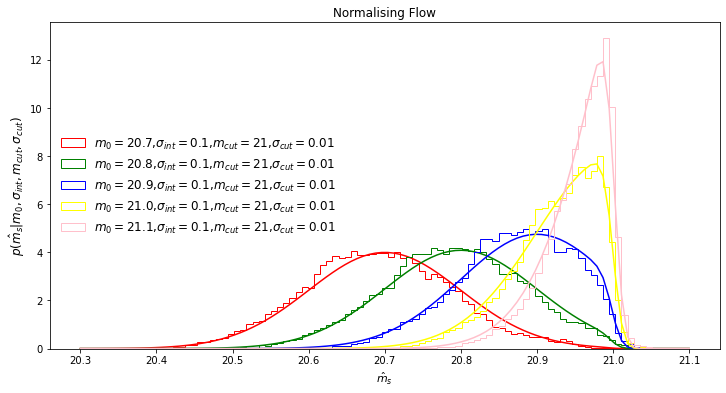

epoch:  4001  loss:  -0.8589279800199034
epoch:  4002  loss:  -1.2404725425006955
epoch:  4003  loss:  -0.9440751138721892
epoch:  4004  loss:  -1.0392833842639297
epoch:  4005  loss:  -1.1865558918387116
epoch:  4006  loss:  -0.7051058399208278
epoch:  4007  loss:  -0.7223654942376907
epoch:  4008  loss:  -1.112764286003329
epoch:  4009  loss:  -0.9837668359019915
epoch:  4010  loss:  -0.8963856904365177
epoch:  4011  loss:  -1.3082595198352138
epoch:  4012  loss:  -1.0111412625719298
epoch:  4013  loss:  -0.763564515859078
epoch:  4014  loss:  -0.9687972005911795
epoch:  4015  loss:  -0.909708952045994
epoch:  4016  loss:  -0.023089593219569188
epoch:  4017  loss:  -1.325672674867209
epoch:  4018  loss:  -0.9936732595972062
epoch:  4019  loss:  -0.9514122453515905
epoch:  4020  loss:  -0.868548369540378
epoch:  4021  loss:  -1.1237687114923869
epoch:  4022  loss:  -1.0194428439430827
epoch:  4023  loss:  -0.8731312525006277
epoch:  4024  loss:  -0.86853504359975
epoch:  4025  loss:  

epoch:  4202  loss:  -0.7281815880105842
epoch:  4203  loss:  -1.396619678454469
epoch:  4204  loss:  -0.9091274271607668
epoch:  4205  loss:  -0.8643077535268933
epoch:  4206  loss:  -1.0885598560002059
epoch:  4207  loss:  -1.195978330637127
epoch:  4208  loss:  -0.2243824556839774
epoch:  4209  loss:  -0.8644075923686134
epoch:  4210  loss:  -1.0490654524939298
epoch:  4211  loss:  -1.0612001067789034
epoch:  4212  loss:  -1.0986240111956784
epoch:  4213  loss:  -0.9414136328641441
epoch:  4214  loss:  -1.3356520770942717
epoch:  4215  loss:  -1.153634289636951
epoch:  4216  loss:  -0.7202868028144351
epoch:  4217  loss:  -1.3284345637900319
epoch:  4218  loss:  -1.4209870472903254
epoch:  4219  loss:  -0.8736366746687423
epoch:  4220  loss:  -1.2374350541461252
epoch:  4221  loss:  -0.7018939841500712
epoch:  4222  loss:  1.6336232085849192
epoch:  4223  loss:  -1.3385759707826983
epoch:  4224  loss:  -0.9064433277865122
epoch:  4225  loss:  -0.625451344827981
epoch:  4226  loss:  

epoch:  4405  loss:  -0.8571109848905576
epoch:  4406  loss:  -0.6457487508981531
epoch:  4407  loss:  -0.9407340491731518
epoch:  4408  loss:  -1.025370162072563
epoch:  4409  loss:  -0.5938041436706422
epoch:  4410  loss:  -0.9011420136589721
epoch:  4411  loss:  -1.1681293377001367
epoch:  4412  loss:  -1.1190326818435279
epoch:  4413  loss:  -0.269269993448927
epoch:  4414  loss:  -1.388513481625875
epoch:  4415  loss:  -1.2688319062843667
epoch:  4416  loss:  -0.9996563966093459
epoch:  4417  loss:  -0.8286713919612421
epoch:  4418  loss:  -1.4021895138445253
epoch:  4419  loss:  -0.9305389665752719
epoch:  4420  loss:  -1.1841298953794597
epoch:  4421  loss:  -1.3471979704202286
epoch:  4422  loss:  -0.8305423269668684
epoch:  4423  loss:  -1.2322389027645304
epoch:  4424  loss:  -1.0720125971923717
epoch:  4425  loss:  -0.9791232594711646
epoch:  4426  loss:  -0.9661025119936176
epoch:  4427  loss:  -1.0999366369458707
epoch:  4428  loss:  -0.96117934971531
epoch:  4429  loss:  

epoch:  4608  loss:  -1.1210983331849655
epoch:  4609  loss:  -1.0729420423481033
epoch:  4610  loss:  -1.0452680290348941
epoch:  4611  loss:  -0.6777785682210568
epoch:  4612  loss:  -1.2988698830693814
epoch:  4613  loss:  -0.8722872278065218
epoch:  4614  loss:  -1.0043752718270578
epoch:  4615  loss:  -0.7363846905809548
epoch:  4616  loss:  -1.057290967406709
epoch:  4617  loss:  -0.6457106424841687
epoch:  4618  loss:  -1.0814804503784567
epoch:  4619  loss:  -1.123613699445799
epoch:  4620  loss:  -1.3459411795697425
epoch:  4621  loss:  -1.023619116913436
epoch:  4622  loss:  -0.8902644099256354
epoch:  4623  loss:  -1.1171153160275753
epoch:  4624  loss:  -1.3335571706464058
epoch:  4625  loss:  -0.8490799762455598
epoch:  4626  loss:  -1.241593906652565
epoch:  4627  loss:  -1.160956359122825
epoch:  4628  loss:  -1.0620887523914448
epoch:  4629  loss:  -1.679627427763457
epoch:  4630  loss:  -0.7532706606323433
epoch:  4631  loss:  -0.9587871146755054
epoch:  4632  loss:  -

epoch:  4809  loss:  -1.0261260569490986
epoch:  4810  loss:  -1.1010996200373393
epoch:  4811  loss:  -0.857801210719491
epoch:  4812  loss:  -0.925086910459577
epoch:  4813  loss:  -0.9721796446651096
epoch:  4814  loss:  -1.0952903115616168
epoch:  4815  loss:  -1.1325653368791304
epoch:  4816  loss:  -1.1466934549114893
epoch:  4817  loss:  -1.2410430294904278
epoch:  4818  loss:  -1.166936469698722
epoch:  4819  loss:  -1.0784673033881567
epoch:  4820  loss:  -1.0869382960390932
epoch:  4821  loss:  -0.5857417649826646
epoch:  4822  loss:  -0.8798284478633757
epoch:  4823  loss:  -1.2444637836334336
epoch:  4824  loss:  -1.0753303983438567
epoch:  4825  loss:  -0.8807089381103455
epoch:  4826  loss:  -1.0563161710793387
epoch:  4827  loss:  -0.6502306590613203
epoch:  4828  loss:  -1.088277184993584
epoch:  4829  loss:  -1.1013900066973037
epoch:  4830  loss:  -0.9651979954002479
epoch:  4831  loss:  -0.7986577150998055
epoch:  4832  loss:  -1.0468883582383512
epoch:  4833  loss: 

epoch:  5010  loss:  -0.8865422405748886
epoch:  5011  loss:  -0.7749691064345005
epoch:  5012  loss:  -0.8973037374904105
epoch:  5013  loss:  0.1294530477410539
epoch:  5014  loss:  -1.1680504905182587
epoch:  5015  loss:  -1.0615028745185406
epoch:  5016  loss:  0.5475974942286537
epoch:  5017  loss:  -1.29270552699275
epoch:  5018  loss:  -1.1725975484582327
epoch:  5019  loss:  -0.9660414216564643
epoch:  5020  loss:  -0.6982448277702749
epoch:  5021  loss:  -0.9049595902311419
epoch:  5022  loss:  -1.0635232352602189
epoch:  5023  loss:  -0.6959384363678569
epoch:  5024  loss:  -0.9335483799915691
epoch:  5025  loss:  -1.1281142855306812
epoch:  5026  loss:  -0.8329649167573184
epoch:  5027  loss:  -0.8237549575861085
epoch:  5028  loss:  -0.765417914394623
epoch:  5029  loss:  -1.277824127495721
epoch:  5030  loss:  -1.3524862503188229
epoch:  5031  loss:  -0.66623159453618
epoch:  5032  loss:  -1.3350938227940574
epoch:  5033  loss:  -1.015281973236232
epoch:  5034  loss:  -0.8

epoch:  5212  loss:  -1.1025868936452217
epoch:  5213  loss:  -1.095729586114458
epoch:  5214  loss:  -1.2704244028197718
epoch:  5215  loss:  -0.8392999592744965
epoch:  5216  loss:  -0.8149583063231398
epoch:  5217  loss:  -0.7156759885211045
epoch:  5218  loss:  -0.8759894040185017
epoch:  5219  loss:  -0.8957593635065323
epoch:  5220  loss:  -1.0447422986077672
epoch:  5221  loss:  -1.2152499097512035
epoch:  5222  loss:  -1.3185704282597568
epoch:  5223  loss:  -1.018542937649638
epoch:  5224  loss:  -1.190999338665748
epoch:  5225  loss:  -0.5760596247556117
epoch:  5226  loss:  -0.9485751544025239
epoch:  5227  loss:  -1.3034819479589492
epoch:  5228  loss:  -0.9550408391029817
epoch:  5229  loss:  -0.7470223273030415
epoch:  5230  loss:  -0.9711500874686487
epoch:  5231  loss:  -0.9484061782392221
epoch:  5232  loss:  -0.7403048161810195
epoch:  5233  loss:  -0.8683581051728384
epoch:  5234  loss:  -1.021282396078502
epoch:  5235  loss:  -1.1051063507336116
epoch:  5236  loss: 

epoch:  5415  loss:  -0.7747016713483511
epoch:  5416  loss:  -1.1155289296840973
epoch:  5417  loss:  -1.2459275966770824
epoch:  5418  loss:  -1.008145341243904
epoch:  5419  loss:  -0.6614230911448173
epoch:  5420  loss:  -1.0190288853896592
epoch:  5421  loss:  -0.5685569527694084
epoch:  5422  loss:  -0.9653146940470554
epoch:  5423  loss:  -1.1510687876120596
epoch:  5424  loss:  -0.8867104695921494
epoch:  5425  loss:  -1.0023155106554409
epoch:  5426  loss:  -1.0913925348723366
epoch:  5427  loss:  -0.9952371480220751
epoch:  5428  loss:  -0.8538556221983565
epoch:  5429  loss:  -1.0282543999421891
epoch:  5430  loss:  -1.2053893443068628
epoch:  5431  loss:  -0.9174874493315252
epoch:  5432  loss:  -1.0796260244886136
epoch:  5433  loss:  -0.8595775171424364
epoch:  5434  loss:  1.209539533661893
epoch:  5435  loss:  0.9686820017149215
epoch:  5436  loss:  -1.0477143696718492
epoch:  5437  loss:  -0.7876370187308175
epoch:  5438  loss:  -1.0241670794846367
epoch:  5439  loss: 

epoch:  5616  loss:  -0.7673876809965974
epoch:  5617  loss:  -0.977061907685924
epoch:  5618  loss:  1.5672793386018802
epoch:  5619  loss:  -0.3573379629513489
epoch:  5620  loss:  -0.6745041091779305
epoch:  5621  loss:  -0.7050692336469343
epoch:  5622  loss:  -0.9672417882247945
epoch:  5623  loss:  -0.40505085319477496
epoch:  5624  loss:  -1.1774335010891643
epoch:  5625  loss:  -1.2108690198172034
epoch:  5626  loss:  -0.7353695978658901
epoch:  5627  loss:  -0.4648304962508149
epoch:  5628  loss:  -0.7937994006594522
epoch:  5629  loss:  -0.8951442829096362
epoch:  5630  loss:  -0.9327996742880198
epoch:  5631  loss:  -1.2065869894724444
epoch:  5632  loss:  -1.1682060805630545
epoch:  5633  loss:  -1.1137585404614119
epoch:  5634  loss:  -1.1105512899578867
epoch:  5635  loss:  -1.0723995142519533
epoch:  5636  loss:  -0.963248448531617
epoch:  5637  loss:  -0.9834169795587989
epoch:  5638  loss:  -1.0698305002149624
epoch:  5639  loss:  -0.9786276027929014
epoch:  5640  loss

epoch:  5819  loss:  -1.0358690551707146
epoch:  5820  loss:  -0.9630445427841912
epoch:  5821  loss:  -0.9401950120358538
epoch:  5822  loss:  -1.0541352591821986
epoch:  5823  loss:  -0.771429222243521
epoch:  5824  loss:  -1.1700656800906082
epoch:  5825  loss:  0.5158797639538256
epoch:  5826  loss:  -1.0187444337712486
epoch:  5827  loss:  -0.7597537970688568
epoch:  5828  loss:  -1.1452298690794365
epoch:  5829  loss:  -1.062860937508986
epoch:  5830  loss:  -0.5991710337736956
epoch:  5831  loss:  -1.091115841851145
epoch:  5832  loss:  -0.8714270472765347
epoch:  5833  loss:  -0.9197895493158642
epoch:  5834  loss:  -0.8915803186290286
epoch:  5835  loss:  -0.9062615642233023
epoch:  5836  loss:  -0.9669477331727524
epoch:  5837  loss:  -0.9712254328005068
epoch:  5838  loss:  -0.793675362606338
epoch:  5839  loss:  -0.6094874617650774
epoch:  5840  loss:  -0.9454328795198671
epoch:  5841  loss:  -0.7522489086639705
epoch:  5842  loss:  -1.1755270570736562
epoch:  5843  loss:  

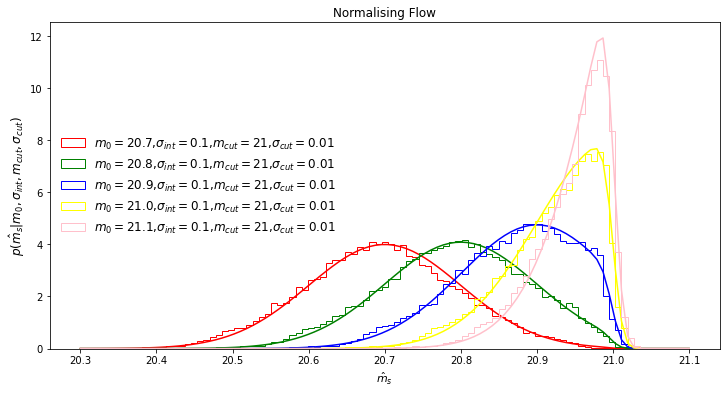

epoch:  6001  loss:  -1.4625836796826024
epoch:  6002  loss:  -1.0875913428619925
epoch:  6003  loss:  -0.8083088625974092
epoch:  6004  loss:  -0.6060992296731101
epoch:  6005  loss:  -1.244711703291578
epoch:  6006  loss:  -1.1628316098233176
epoch:  6007  loss:  -1.1718708548964738
epoch:  6008  loss:  -1.098164372086128
epoch:  6009  loss:  -0.9960273525747925
epoch:  6010  loss:  -1.145307619734799
epoch:  6011  loss:  -0.8620951717385852
epoch:  6012  loss:  -0.8020466429506486
epoch:  6013  loss:  -0.685534766415335
epoch:  6014  loss:  -0.6468622058844308
epoch:  6015  loss:  -0.8815554071926865
epoch:  6016  loss:  -1.1783425412360158
epoch:  6017  loss:  -0.8900313809155376
epoch:  6018  loss:  -1.1820419808798752
epoch:  6019  loss:  -0.8592671846543699
epoch:  6020  loss:  -0.502552824141374
epoch:  6021  loss:  -1.047824385704318
epoch:  6022  loss:  -0.9114973526127019
epoch:  6023  loss:  -1.1500685973629712
epoch:  6024  loss:  -1.141736821787149
epoch:  6025  loss:  -0

epoch:  6204  loss:  -1.3278682219024114
epoch:  6205  loss:  -0.6696755183868516
epoch:  6206  loss:  -0.9331306977084075
epoch:  6207  loss:  -0.7508242160769466
epoch:  6208  loss:  -0.9286089127287771
epoch:  6209  loss:  -1.2733875207596537
epoch:  6210  loss:  -0.8989404258029501
epoch:  6211  loss:  -1.233993427232611
epoch:  6212  loss:  -1.080740373533821
epoch:  6213  loss:  -1.0886893018651878
epoch:  6214  loss:  1.549563304156928
epoch:  6215  loss:  -1.1533327457334537
epoch:  6216  loss:  -1.1952411680902755
epoch:  6217  loss:  -0.9543396690810769
epoch:  6218  loss:  -0.611218590575222
epoch:  6219  loss:  -0.9206297706937792
epoch:  6220  loss:  -0.9067549157818989
epoch:  6221  loss:  -1.0395274497968083
epoch:  6222  loss:  -1.0055573673818035
epoch:  6223  loss:  -1.1708796944334772
epoch:  6224  loss:  -0.5784255464276307
epoch:  6225  loss:  -0.6384370005483317
epoch:  6226  loss:  -0.8618830968793477
epoch:  6227  loss:  -1.1336038662423384
epoch:  6228  loss:  

epoch:  6406  loss:  -1.1627299421050745
epoch:  6407  loss:  -0.9370363547179539
epoch:  6408  loss:  -1.150535229948046
epoch:  6409  loss:  -1.0710524179860192
epoch:  6410  loss:  -0.7102703284308561
epoch:  6411  loss:  -1.0086948457566653
epoch:  6412  loss:  -1.0445630237207115
epoch:  6413  loss:  -1.1400025676863177
epoch:  6414  loss:  -0.9097243716210549
epoch:  6415  loss:  -1.1856357040958356
epoch:  6416  loss:  -1.5912699562485542
epoch:  6417  loss:  -0.5816725790946452
epoch:  6418  loss:  -1.0080495011751962
epoch:  6419  loss:  -1.0989191023835978
epoch:  6420  loss:  -0.7784685014193954
epoch:  6421  loss:  -1.0013191815869158
epoch:  6422  loss:  -1.2804630623255417
epoch:  6423  loss:  1.2791305936289663
epoch:  6424  loss:  -1.0295800802941286
epoch:  6425  loss:  -1.044725187447264
epoch:  6426  loss:  -0.8336449752479564
epoch:  6427  loss:  -1.3992407411303227
epoch:  6428  loss:  -1.2691214565822713
epoch:  6429  loss:  -1.2346929570029697
epoch:  6430  loss:

epoch:  6607  loss:  -1.1750472398759362
epoch:  6608  loss:  -0.9048373901055871
epoch:  6609  loss:  0.4792593525982934
epoch:  6610  loss:  -1.210173408666352
epoch:  6611  loss:  -1.0339484873997091
epoch:  6612  loss:  -0.8307376011992128
epoch:  6613  loss:  -1.1081173807538367
epoch:  6614  loss:  -0.9530587032262313
epoch:  6615  loss:  1.0596842984263768
epoch:  6616  loss:  -0.7444209256273739
epoch:  6617  loss:  -0.8391042352046629
epoch:  6618  loss:  -1.1939550009117357
epoch:  6619  loss:  -0.8088022602679367
epoch:  6620  loss:  0.6767262362935673
epoch:  6621  loss:  -1.0730974247602585
epoch:  6622  loss:  -1.1345995223152645
epoch:  6623  loss:  -0.1984013879825844
epoch:  6624  loss:  -1.2349021622273153
epoch:  6625  loss:  -0.988426643158882
epoch:  6626  loss:  -0.9830232199981883
epoch:  6627  loss:  -0.9727990404721034
epoch:  6628  loss:  -0.8322985835375865
epoch:  6629  loss:  -1.1948863634299511
epoch:  6630  loss:  -0.910180580333675
epoch:  6631  loss:  1

epoch:  6808  loss:  -1.0714541565722133
epoch:  6809  loss:  -1.2124868481155215
epoch:  6810  loss:  -1.230925233635756
epoch:  6811  loss:  -0.6849884498907634
epoch:  6812  loss:  -0.93206387457549
epoch:  6813  loss:  -0.8131033418105357
epoch:  6814  loss:  -0.9024226049957447
epoch:  6815  loss:  -0.05700926707024546
epoch:  6816  loss:  -1.1020276365776944
epoch:  6817  loss:  -0.8839436995135787
epoch:  6818  loss:  -0.9247193906569551
epoch:  6819  loss:  -0.47651048292652465
epoch:  6820  loss:  -0.8286863932825407
epoch:  6821  loss:  -0.8190022385779493
epoch:  6822  loss:  -0.9629798265524077
epoch:  6823  loss:  -1.1039130500250132
epoch:  6824  loss:  -1.0873033631759164
epoch:  6825  loss:  -1.3772801381421873
epoch:  6826  loss:  -0.6293878459800585
epoch:  6827  loss:  -1.154854218846841
epoch:  6828  loss:  -0.991064599257546
epoch:  6829  loss:  -0.7837468126166909
epoch:  6830  loss:  -0.9230593343737162
epoch:  6831  loss:  -1.0578657480496005
epoch:  6832  loss:

epoch:  7009  loss:  -1.0689700606723327
epoch:  7010  loss:  -0.7865057117464005
epoch:  7011  loss:  -1.160587806254092
epoch:  7012  loss:  -1.008631777212735
epoch:  7013  loss:  -1.0284131304777593
epoch:  7014  loss:  -1.1091780359982701
epoch:  7015  loss:  -0.8791690003911259
epoch:  7016  loss:  -1.2049790218475012
epoch:  7017  loss:  -1.2001406254694467
epoch:  7018  loss:  -0.806428873407849
epoch:  7019  loss:  -1.2915187890326625
epoch:  7020  loss:  -1.3599237304522958
epoch:  7021  loss:  -0.6395311293333694
epoch:  7022  loss:  -1.072036978099484
epoch:  7023  loss:  -1.160306848831811
epoch:  7024  loss:  -1.1396570514881146
epoch:  7025  loss:  -0.9263764813521778
epoch:  7026  loss:  -0.9800132980059082
epoch:  7027  loss:  -0.9547492679412724
epoch:  7028  loss:  -0.8257897354570461
epoch:  7029  loss:  -1.0189027089189775
epoch:  7030  loss:  -1.070267871394302
epoch:  7031  loss:  -0.8935489110183245
epoch:  7032  loss:  -0.8840125177460828
epoch:  7033  loss:  -

epoch:  7210  loss:  -1.214062910393263
epoch:  7211  loss:  -1.1254885098748837
epoch:  7212  loss:  -1.119789864314731
epoch:  7213  loss:  -0.8018484210837922
epoch:  7214  loss:  -0.7907705945014502
epoch:  7215  loss:  -1.030042805629686
epoch:  7216  loss:  -0.9397196645483696
epoch:  7217  loss:  -1.2081920994003859
epoch:  7218  loss:  -1.138539643168934
epoch:  7219  loss:  -0.9646112232617752
epoch:  7220  loss:  -1.174589992986353
epoch:  7221  loss:  -0.9351988139247263
epoch:  7222  loss:  -1.2241303275922948
epoch:  7223  loss:  -0.8172289721409729
epoch:  7224  loss:  -1.236253082500664
epoch:  7225  loss:  -0.8140847238823169
epoch:  7226  loss:  -1.1021201826901004
epoch:  7227  loss:  -0.7241088974148198
epoch:  7228  loss:  -1.043350811139252
epoch:  7229  loss:  -1.4111947471254784
epoch:  7230  loss:  -1.299591411861173
epoch:  7231  loss:  -1.0761471552210773
epoch:  7232  loss:  -0.9696445195073982
epoch:  7233  loss:  -1.0970204530773453
epoch:  7234  loss:  -0.

epoch:  7411  loss:  -0.8526485995085377
epoch:  7412  loss:  -1.1784747319671474
epoch:  7413  loss:  -0.7233209376350018
epoch:  7414  loss:  -1.0354046572848734
epoch:  7415  loss:  -0.9554377066500022
epoch:  7416  loss:  -1.1513039251502715
epoch:  7417  loss:  -0.3971455218549621
epoch:  7418  loss:  -0.5801295134466403
epoch:  7419  loss:  -0.9330895138257711
epoch:  7420  loss:  -1.1149352416968976
epoch:  7421  loss:  -0.9815365845473298
epoch:  7422  loss:  -1.2674893240207534
epoch:  7423  loss:  -1.119916425019012
epoch:  7424  loss:  -1.1108704174747581
epoch:  7425  loss:  -1.0265274822765145
epoch:  7426  loss:  -0.7037371534219726
epoch:  7427  loss:  -1.0760500454655624
epoch:  7428  loss:  -1.2687119680051426
epoch:  7429  loss:  -1.3032225912173379
epoch:  7430  loss:  -1.1018324422158274
epoch:  7431  loss:  -1.184957944070802
epoch:  7432  loss:  -1.2423875958124646
epoch:  7433  loss:  -0.7907373967583722
epoch:  7434  loss:  -1.1699475783244537
epoch:  7435  loss

epoch:  7612  loss:  0.02689376561284297
epoch:  7613  loss:  -0.8200691902562478
epoch:  7614  loss:  -0.9245255672939996
epoch:  7615  loss:  -0.7865572684347666
epoch:  7616  loss:  -0.7549211623187239
epoch:  7617  loss:  -0.9192012339990497
epoch:  7618  loss:  -0.9864115519508806
epoch:  7619  loss:  -0.8370644582382573
epoch:  7620  loss:  0.17254719524313097
epoch:  7621  loss:  0.23339574793344053
epoch:  7622  loss:  -1.143517753269086
epoch:  7623  loss:  -1.0524222263009055
epoch:  7624  loss:  -1.1057946693978429
epoch:  7625  loss:  -0.3613625134694976
epoch:  7626  loss:  -1.141390285858481
epoch:  7627  loss:  -1.0691014795164606
epoch:  7628  loss:  -1.0856278254969467
epoch:  7629  loss:  -1.216065339270945
epoch:  7630  loss:  -0.8727447800054273
epoch:  7631  loss:  -1.1871423398276089
epoch:  7632  loss:  -0.5252140069752269
epoch:  7633  loss:  -1.0510876982298494
epoch:  7634  loss:  -1.0742054110423023
epoch:  7635  loss:  -1.2607181918309784
epoch:  7636  loss:

epoch:  7813  loss:  -0.9383301929099946
epoch:  7814  loss:  -0.35896155684206327
epoch:  7815  loss:  -1.137994524385747
epoch:  7816  loss:  -1.2968317600005157
epoch:  7817  loss:  -1.1713874448198596
epoch:  7818  loss:  -1.0941223496292687
epoch:  7819  loss:  -1.0912945149579862
epoch:  7820  loss:  -0.3886467310211341
epoch:  7821  loss:  -1.1679564490183776
epoch:  7822  loss:  -1.153393957609956
epoch:  7823  loss:  -1.039668380742333
epoch:  7824  loss:  -0.9055750915731371
epoch:  7825  loss:  -0.8874351405790191
epoch:  7826  loss:  -1.3199599736083958
epoch:  7827  loss:  -1.1181442524703857
epoch:  7828  loss:  -1.0781362793870348
epoch:  7829  loss:  -0.9688973321692177
epoch:  7830  loss:  -1.3239064303552415
epoch:  7831  loss:  1.4574767377919362
epoch:  7832  loss:  -1.2063909438528388
epoch:  7833  loss:  -0.7453883962464218
epoch:  7834  loss:  -1.162790063820156
epoch:  7835  loss:  -0.7126441776713848
epoch:  7836  loss:  -1.2503944561171456
epoch:  7837  loss: 

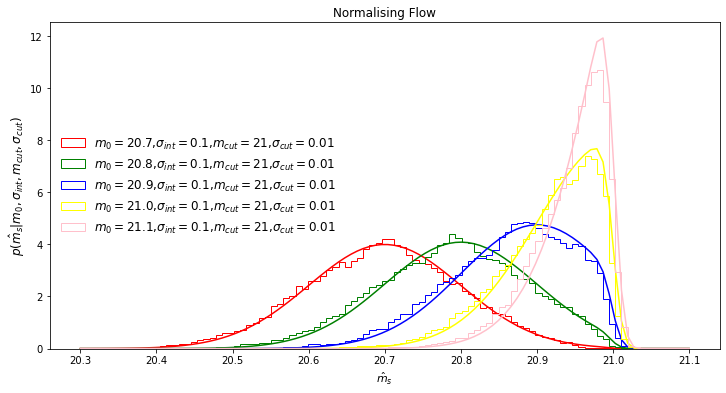

epoch:  8001  loss:  -1.302519523272373
epoch:  8002  loss:  -1.215294988253288
epoch:  8003  loss:  -1.1570196624246893
epoch:  8004  loss:  -0.6286352303521796
epoch:  8005  loss:  -0.7651974632224775
epoch:  8006  loss:  -0.8800086825425827
epoch:  8007  loss:  -1.4296892886930268
epoch:  8008  loss:  -1.2609193093898838
epoch:  8009  loss:  -1.0848435177843907
epoch:  8010  loss:  -0.9017441054705823
epoch:  8011  loss:  0.42277283964846885
epoch:  8012  loss:  -0.8806622661307545
epoch:  8013  loss:  -0.9029051871824549
epoch:  8014  loss:  -0.8867619390821392
epoch:  8015  loss:  -1.2971361910783064
epoch:  8016  loss:  -1.1925879398513268
epoch:  8017  loss:  -1.1898923848569793
epoch:  8018  loss:  -1.231478704904139
epoch:  8019  loss:  -1.3968730462009116
epoch:  8020  loss:  -0.7386140530310734
epoch:  8021  loss:  -0.9448725593256244
epoch:  8022  loss:  -0.9302392159666799
epoch:  8023  loss:  -1.3771565330851208
epoch:  8024  loss:  -0.896537681583802
epoch:  8025  loss: 

epoch:  8204  loss:  -0.8646237058678173
epoch:  8205  loss:  -0.989038494310676
epoch:  8206  loss:  -1.243350638481947
epoch:  8207  loss:  -0.7348130325666178
epoch:  8208  loss:  -1.0258080175579505
epoch:  8209  loss:  -0.9619545970970885
epoch:  8210  loss:  -0.8960152967030413
epoch:  8211  loss:  -1.1081934356279048
epoch:  8212  loss:  -1.000380206132202
epoch:  8213  loss:  -1.0120627769059511
epoch:  8214  loss:  -1.4595991037249783
epoch:  8215  loss:  -1.044834674426708
epoch:  8216  loss:  -1.108927642957623
epoch:  8217  loss:  -0.8608258475314766
epoch:  8218  loss:  -1.27147296798712
epoch:  8219  loss:  -0.858372873321546
epoch:  8220  loss:  -1.1616718682737779
epoch:  8221  loss:  -1.0798628125606238
epoch:  8222  loss:  -0.7213529977746324
epoch:  8223  loss:  1.4048826053213435
epoch:  8224  loss:  -1.3596867939454147
epoch:  8225  loss:  -1.0984489611316122
epoch:  8226  loss:  -0.8891283857013792
epoch:  8227  loss:  -1.1774247986257855
epoch:  8228  loss:  -0.8

epoch:  8405  loss:  -1.2984724085643453
epoch:  8406  loss:  -1.320621751678082
epoch:  8407  loss:  -0.7130245441823323
epoch:  8408  loss:  -1.1476193308699272
epoch:  8409  loss:  -0.8859194244067913
epoch:  8410  loss:  -1.0433312841777238
epoch:  8411  loss:  -0.7320795880844364
epoch:  8412  loss:  -0.7526780430102251
epoch:  8413  loss:  -0.0385755986246735
epoch:  8414  loss:  -0.8693484421695725
epoch:  8415  loss:  -1.2698767529793273
epoch:  8416  loss:  -0.5692548309532883
epoch:  8417  loss:  -1.0516212682455213
epoch:  8418  loss:  -1.1234677467991814
epoch:  8419  loss:  -0.8236623407502291
epoch:  8420  loss:  -0.1520330098451018
epoch:  8421  loss:  -1.0353064226659836
epoch:  8422  loss:  -0.9520296348367278
epoch:  8423  loss:  -0.8947384630879981
epoch:  8424  loss:  -0.9728650208942993
epoch:  8425  loss:  -1.0638107010551314
epoch:  8426  loss:  -0.5877355587282462
epoch:  8427  loss:  -1.2277276027896777
epoch:  8428  loss:  -0.8717303702604229
epoch:  8429  los

epoch:  8606  loss:  0.5805758173128822
epoch:  8607  loss:  -1.1229242963257768
epoch:  8608  loss:  -0.9418416221284868
epoch:  8609  loss:  -1.0163767194892304
epoch:  8610  loss:  -0.681464970803571
epoch:  8611  loss:  -0.7464153386887662
epoch:  8612  loss:  -1.3191455806653878
epoch:  8613  loss:  -1.132634921288587
epoch:  8614  loss:  -1.029005429208478
epoch:  8615  loss:  -0.9252024719235656
epoch:  8616  loss:  -1.0592177273281012
epoch:  8617  loss:  -1.1747292360584243
epoch:  8618  loss:  2.600085509905016
epoch:  8619  loss:  -1.0556084030412416
epoch:  8620  loss:  -0.5626896688360493
epoch:  8621  loss:  -0.9593952023534899
epoch:  8622  loss:  -1.318814951899137
epoch:  8623  loss:  -0.8040198541129884
epoch:  8624  loss:  -0.976424195728739
epoch:  8625  loss:  -0.9221682572829966
epoch:  8626  loss:  -0.9073356579364427
epoch:  8627  loss:  -1.0571657011582312
epoch:  8628  loss:  -1.0570091201630796
epoch:  8629  loss:  -0.7977869885768196
epoch:  8630  loss:  -0.

epoch:  8810  loss:  -1.333180879317802
epoch:  8811  loss:  -1.2097947456543834
epoch:  8812  loss:  -0.8905851932136423
epoch:  8813  loss:  -0.8560874934960914
epoch:  8814  loss:  -0.9185689483943092
epoch:  8815  loss:  -1.012327070948711
epoch:  8816  loss:  -1.1055377723346043
epoch:  8817  loss:  -0.8264420554297479
epoch:  8818  loss:  -0.9969329352208703
epoch:  8819  loss:  -0.9430623996336492
epoch:  8820  loss:  -0.862827556148979
epoch:  8821  loss:  -1.488691043772412
epoch:  8822  loss:  -0.8463932365289577
epoch:  8823  loss:  -0.9898621251968713
epoch:  8824  loss:  -1.0899172824332968
epoch:  8825  loss:  -1.0633696885836939
epoch:  8826  loss:  -0.8648215751846624
epoch:  8827  loss:  -0.7425798271764238
epoch:  8828  loss:  -0.9449026069875759
epoch:  8829  loss:  -1.2194057167082832
epoch:  8830  loss:  -0.9374032913518586
epoch:  8831  loss:  -0.7936398729625089
epoch:  8832  loss:  -0.9137713106337567
epoch:  8833  loss:  -0.9679772037952094
epoch:  8834  loss: 

epoch:  9011  loss:  -1.2542089500521039
epoch:  9012  loss:  -1.0371901778182835
epoch:  9013  loss:  -1.1486626083757348
epoch:  9014  loss:  -1.106319888269959
epoch:  9015  loss:  -0.9766046950153218
epoch:  9016  loss:  -1.0474392288247931
epoch:  9017  loss:  -1.4372325862591961
epoch:  9018  loss:  -1.3049380208747299
epoch:  9019  loss:  -1.1270266491741354
epoch:  9020  loss:  -1.2236706024730557
epoch:  9021  loss:  -0.7718031140922978
epoch:  9022  loss:  -0.8145976495510782
epoch:  9023  loss:  -1.1315416943393244
epoch:  9024  loss:  -0.8261228487950324
epoch:  9025  loss:  -0.8068546534384577
epoch:  9026  loss:  -0.939934570479997
epoch:  9027  loss:  -0.8057511261448627
epoch:  9028  loss:  0.9146783680544308
epoch:  9029  loss:  -1.1414575970711736
epoch:  9030  loss:  -0.9603304692670732
epoch:  9031  loss:  -0.4922793928017322
epoch:  9032  loss:  0.20300565723904304
epoch:  9033  loss:  -0.9763400960335402
epoch:  9034  loss:  -1.098951496082974
epoch:  9035  loss: 

epoch:  9212  loss:  -0.9932971136190349
epoch:  9213  loss:  -0.8428648224899055
epoch:  9214  loss:  -1.0782573001547353
epoch:  9215  loss:  -0.9789505746535972
epoch:  9216  loss:  -1.022865398003319
epoch:  9217  loss:  -1.1115927944724244
epoch:  9218  loss:  -1.1379422300109996
epoch:  9219  loss:  -0.885312658379841
epoch:  9220  loss:  -1.1007169935618284
epoch:  9221  loss:  -0.9357278357203822
epoch:  9222  loss:  -1.2639172053469434
epoch:  9223  loss:  -1.1027630202232812
epoch:  9224  loss:  -0.9728717171524055
epoch:  9225  loss:  -0.5743226648522342
epoch:  9226  loss:  -1.0894197724201995
epoch:  9227  loss:  -0.7148874326254406
epoch:  9228  loss:  -0.9649994734864672
epoch:  9229  loss:  -0.6864802340575874
epoch:  9230  loss:  -1.2544102635576666
epoch:  9231  loss:  -0.29786982212685054
epoch:  9232  loss:  -0.9925532118773366
epoch:  9233  loss:  -1.1594036813786501
epoch:  9234  loss:  -1.0482124120782919
epoch:  9235  loss:  0.3548710935873409
epoch:  9236  loss

epoch:  9413  loss:  -1.1811490193773466
epoch:  9414  loss:  -1.4613311751551443
epoch:  9415  loss:  -1.148862733700269
epoch:  9416  loss:  -0.5931053879475965
epoch:  9417  loss:  -1.0742007063322236
epoch:  9418  loss:  -0.9658748202806996
epoch:  9419  loss:  -1.0045471908792212
epoch:  9420  loss:  -0.866104819983565
epoch:  9421  loss:  -0.5668150790168605
epoch:  9422  loss:  -1.1592335231094404
epoch:  9423  loss:  -1.1305224125872548
epoch:  9424  loss:  -1.2001976731605701
epoch:  9425  loss:  -0.7664583779463783
epoch:  9426  loss:  -0.9342719955801198
epoch:  9427  loss:  -0.9039080967324724
epoch:  9428  loss:  -1.3017347919343039
epoch:  9429  loss:  -1.2655143189797904
epoch:  9430  loss:  -0.9975714998184044
epoch:  9431  loss:  -0.8780162279824623
epoch:  9432  loss:  -1.0171662321756183
epoch:  9433  loss:  -1.146498589510708
epoch:  9434  loss:  -1.1916644334273565
epoch:  9435  loss:  -1.0636448006586487
epoch:  9436  loss:  -0.533922594933944
epoch:  9437  loss: 

epoch:  9614  loss:  1.7923237530802338
epoch:  9615  loss:  -0.1395624941749175
epoch:  9616  loss:  -0.8096357068512473
epoch:  9617  loss:  -0.5819885236920331
epoch:  9618  loss:  -1.5277359785256108
epoch:  9619  loss:  -1.1160984069362172
epoch:  9620  loss:  -1.0308027748201787
epoch:  9621  loss:  -1.2211090634435078
epoch:  9622  loss:  -1.2139949584474188
epoch:  9623  loss:  -0.9761525994117819
epoch:  9624  loss:  -0.8642973919145186
epoch:  9625  loss:  -0.7322694614875966
epoch:  9626  loss:  -1.2452799605601135
epoch:  9627  loss:  0.20393720814840013
epoch:  9628  loss:  -1.1120124035885688
epoch:  9629  loss:  -0.7248421567735056
epoch:  9630  loss:  -0.5013609068604077
epoch:  9631  loss:  -0.7217262722900571
epoch:  9632  loss:  -0.9791970483069167
epoch:  9633  loss:  -0.995862832177652
epoch:  9634  loss:  0.17009745631927417
epoch:  9635  loss:  -1.124324303437501
epoch:  9636  loss:  -0.9661800398897527
epoch:  9637  loss:  -1.0620603342825512
epoch:  9638  loss:

epoch:  9815  loss:  -0.14846445539059566
epoch:  9816  loss:  -0.7902263271909069
epoch:  9817  loss:  -1.313626117251133
epoch:  9818  loss:  -0.9166894261267569
epoch:  9819  loss:  -0.7269208126214903
epoch:  9820  loss:  -0.792399453789958
epoch:  9821  loss:  -0.7566571313676383
epoch:  9822  loss:  -0.9785377285960641
epoch:  9823  loss:  -1.2063493775135272
epoch:  9824  loss:  -1.135530863181044
epoch:  9825  loss:  -0.9690485651738175
epoch:  9826  loss:  1.3630143078438697
epoch:  9827  loss:  -1.0686694220844901
epoch:  9828  loss:  -1.2547191210864035
epoch:  9829  loss:  -1.0587618782027721
epoch:  9830  loss:  -0.8857235403729186
epoch:  9831  loss:  -0.8487716807857116
epoch:  9832  loss:  -0.4879610144039347
epoch:  9833  loss:  -1.0610481356450847
epoch:  9834  loss:  -0.8615035555357433
epoch:  9835  loss:  -1.0402870968626925
epoch:  9836  loss:  -1.2000413507131138
epoch:  9837  loss:  -1.2913525642249557
epoch:  9838  loss:  -0.9322603543468543
epoch:  9839  loss:

In [33]:
from tqdm.notebook import trange
import itertools
import numpy.random as npr
itercount = itertools.count()
sample_batch=1000
batch_size=1000
import logging
itercount = itertools.count()
from IPython.display import clear_output


batch_size=500



for epoch in range(10000):

  sigma_int=0.1
  sigma_cut=0.01
  mu_cut= 21

  permute_rng, rng = random.split(rng)


  mu=random.uniform(rng,(10,)) + 20.5

  permute_rng, rng = random.split(rng)


  s = snp(m_int=mu,sigma_int=sigma_int,m_cut=mu_cut,sigma_cut=sigma_cut)



  samps=s.sample(rng,(100,10))




  X = np.column_stack((samps.T.reshape(1000,),np.repeat(mu.reshape(10,1),100,axis=1).reshape(1000,)))

  if epoch == 0:
      X,min,max=minmax_fit_and_scale(X)

    
  else:
    X  = minmax_scale(X,min,max)




  loss,opt_state = step(next(itercount), opt_state, X)
  params = get_params(opt_state)

  print('epoch: ',epoch,' loss: ', loss)
  
  if epoch % 2000 == 0:
    from matplotlib import pyplot as plt
    c=['red','green','blue','yellow','pink']
    mm = np.array([20.7,20.8,20.9,21,21.1])
    bins=np.linspace(20.3,21.1,100)
    no_samps = 50000


    plt.figure(figsize=(12,6))



    for i,m in enumerate(mm):
    

        samp=sample(rng, params,minmax_scale(np.repeat(np.array([m]),no_samps).reshape(no_samps,1),min[1:],max[1:]),no_samps)
        samp = minmax_unscale(samp[:,0],min[0],max[0])

        plt.hist(samp,density=True,bins=bins,color=c[i],histtype='step',label='$m_0=$'+str(m)+',$\sigma_{int}=$'+str(sigma_int)+',$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))
        s=snp(np.array([m]),np.array([0.1]),21,0.01)
        plt.plot(bins,np.exp(s.log_prob(bins)),color=c[i])
    
        print(np.min(samp),np.max(samp))



    plt.legend(loc='center left',frameon=False,fontsize=12)
    plt.xlabel('$\hat{m}_s$',fontsize=11)
    plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
    plt.title('Normalising Flow',fontsize=12)

    plt.show()

In [34]:
a = np.array([[1,2]])
b = np.array([[3,4]])

print(np.append(a,b,axis=0))

[[1 2]
 [3 4]]


In [35]:
print(X)

[[0.96599465 1.02792733]
 [0.95679083 1.02792733]
 [0.96208833 1.02792733]
 ...
 [0.86428788 0.59831999]
 [0.96346854 0.59831999]
 [0.84467297 0.59831999]]


In [36]:
rng, flow_rng = random.split(random.PRNGKey(0))


def minmax_unscale(X,min,max):
  return X * (max - min) + min




no_samps = 100000

samp=sample(rng, params,minmax_scale(np.repeat(np.array([21.1]),no_samps).reshape(no_samps,1),min[1:],max[1:]),no_samps)

print(samp)

samp = minmax_unscale(samp[:,0],min[0],max[0])



[[0.89610668 0.59501954]
 [0.83045765 0.59501954]
 [0.94042704 0.59501954]
 ...
 [0.73670934 0.59501954]
 [0.81973131 0.59501954]
 [0.78229059 0.59501954]]


In [37]:
print(samp.shape)
print(min)
print(max[1:])


(100000,)
[20.37567124 20.6079846 ]
[21.43487409]


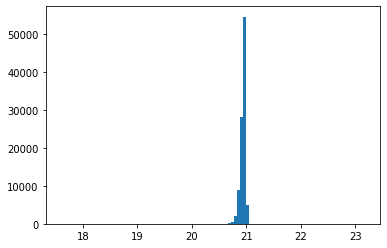

In [38]:
from matplotlib import pyplot as plt
plt.hist(samp,bins=100)
plt.show()

17.592841895199726 23.183648579138065
17.592841895199726 23.183648579138065
17.592841895199726 23.183648579138065
17.592841895199726 23.183648579138065
17.592841895199726 23.183648579138065


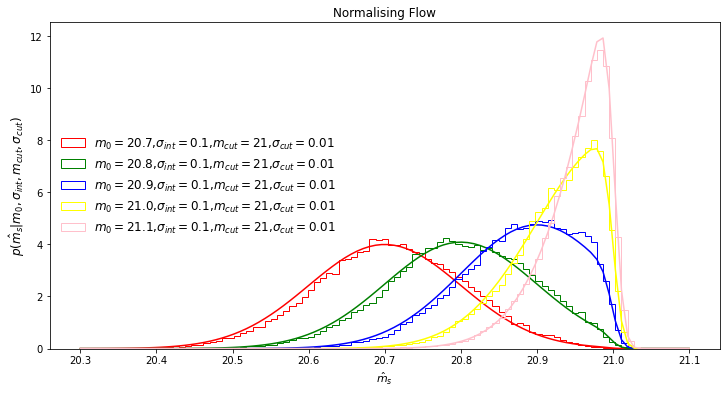

In [39]:
from matplotlib import pyplot as plt
c=['red','green','blue','yellow','pink']
mm = np.array([20.7,20.8,20.9,21,21.1])
bins=np.linspace(20.3,21.1,100)
no_samps = 100000


plt.figure(figsize=(12,6))



for i,m in enumerate(mm):
    

    samp=sample(rng, params,minmax_scale(np.repeat(np.array([m]),no_samps).reshape(no_samps,1),min[1:],max[1:]),no_samps)
    samp = minmax_unscale(samp[:,0],min[0],max[0])

    plt.hist(samp,density=True,bins=bins,color=c[i],histtype='step',label='$m_0=$'+str(m)+',$\sigma_{int}=$'+str(sigma_int)+',$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))
    s=snp(np.array([m]),np.array([0.1]),21,0.01)
    plt.plot(bins,np.exp(s.log_prob(bins)),color=c[i])
    
    print(np.min(samp),np.max(samp))

    #plt.hist(s.sample(rng,(1000,1)).reshape(1000,),density=True,histtype='step')
    

plt.legend(loc='center left',frameon=False,fontsize=12)
plt.xlabel('$\hat{m}_s$',fontsize=11)
plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
plt.title('Normalising Flow',fontsize=12)

plt.show()

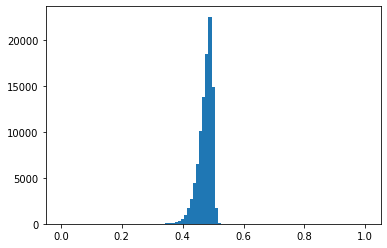

In [15]:
plt.hist(minmax_scale(samp,20,22),bins=minmax_scale(np.linspace(20,22,100),20,22))
plt.show()

In [16]:
 s =

SyntaxError: invalid syntax (3853963735.py, line 1)

In [ ]:
bins = np.linspace(2.75,3.25,100)

plt.hist(samp,density=True,bins=bins)

In [ ]:
plt.hist(samp,bins=100)

In [ ]:
bs=np.arange(10)

XX= np.column_stack((bs,bs))


print(np.repeat(bs.reshape(10,1),5,axis=1).reshape(50,))


In [ ]:
print(X)

In [ ]:

permute_rng, rng = random.split(rng)

s = snp(m_int=np.array([20.99]),sigma_int=0.1,m_cut=21,sigma_cut=0.01)
xxx=s.sample(rng,(10000,1)).reshape(10000,)
rr= np.linspace(np.min(xxx),np.max(xxx),100)
plt.plot(rr,np.exp(s.log_prob(rr)))
plt.hist(xxx,bins=100,density=True)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
sigma_int=0.1
sigma_cut=0.01
mu_cut= 21

permute_rng, rng = random.split(random.PRNGKey(0))


sigma_int=0.1
sigma_cut=0.01
mu_cut= 21

mu=random.uniform(rng,(10,)) + 20.5

permute_rng, rng = random.split(rng)


s = snp(m_int=mu,sigma_int=sigma_int,m_cut=mu_cut,sigma_cut=sigma_cut)



samps=s.sample(rng,(1000,10))




X = np.column_stack((samps.T.reshape(10000,),np.repeat(mu.reshape(10,1),1000,axis=1).reshape(10000,)))







for i in range(10):
  xxx=X[i*1000:(i+1)*1000,0]
  plt.hist(xxx,bins=100,density=True)
  s = snp(m_int=np.array([X[i*1000,1]]),sigma_int=0.1,m_cut=21,sigma_cut=0.01)
  rr= np.linspace(np.min(xxx),np.max(xxx),100)
  plt.plot(rr,np.exp(s.log_prob(rr)))
  plt.show()



In [25]:

print(np.append(np.empty((0,2)),vv,axis=0))

[[0. 1.]
 [2. 3.]
 [4. 5.]
 [6. 7.]
 [8. 9.]]


In [24]:
print(vv)

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
